In [1]:
import numpy as np
import ACO3  as aco
import matplotlib.pyplot as plt

In [2]:
class CVRPInstance:
    def __init__(self):
        self.name = ""
        self.num_trucks = 0
        self.dimension = 0
        self.capacity = 0
        self.depot_x = 0
        self.depot_y = 0
        self.customer_demands = []
        self.customer_x = []
        self.customer_y = []
        self.distances = []

def read_cvrp_instance(file_path):
    instance = CVRPInstance()

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Parsing basic information
        instance.name = lines[0].split(":")[1].strip()

        # Extracting the number of trucks from the comment
        comment_parts = lines[1].split(",")
        for part in comment_parts:
            print("part", part)
            if "No of trucks" in part:
                instance.num_trucks = int(part.split()[-1])
                break

        instance.dimension = int(lines[3].split(":")[1])
        instance.capacity = int(lines[5].split(":")[1])

        # Parsing depot coordinates
        instance.depot_x, instance.depot_y = map(float, lines[7].split()[1:])

        # Parsing customer information
        for line in lines[8:8 + instance.dimension]:
            if line.startswith("DEMAND_SECTION"):
                break
            _, x, y = map(float, line.split())
            instance.customer_x.append(x)
            instance.customer_y.append(y)

        for line in lines[8 + instance.dimension+1:8 + instance.dimension+1+ instance.dimension]:
            if line.startswith("DEPOT_SECTION"):
                break
            _, demand = map(int, line.split())
            instance.customer_demands.append(demand)
        instance.customer_demands = np.array(instance.customer_demands)
        # Calculate distances based on Euclidean distance
        instance.distances = np.zeros((instance.dimension-1, instance.dimension-1))
        for i in range(instance.dimension-1):
            for j in range(instance.dimension-1):
                instance.distances[i][j] = np.sqrt((instance.customer_x[i] - instance.customer_x[j])**2 +
                                                  (instance.customer_y[i] - instance.customer_y[j])**2)

    return instance

# Example usage
file_path = "Vrp-Set-A\A\A-n32-k5.vrp"
cvrp_instance = read_cvrp_instance(file_path)

# Accessing instance attributes
print("Name:               ", cvrp_instance.name)
print("Number of Trucks:   ", cvrp_instance.num_trucks)
print("Dimension:          ", cvrp_instance.dimension)
print("Capacity:           ", cvrp_instance.capacity)
print("Depot coordinates:  ", (cvrp_instance.depot_x, cvrp_instance.depot_y))
# print("Customer demands:   ", cvrp_instance.customer_demands)
print("Distance matrix dim:", cvrp_instance.distances.shape)
# print("Customer distances: ", cvrp_instance.distances)
# print("Customer coordinates:", list(zip(cvrp_instance.customer_x, cvrp_instance.customer_y)))


part COMMENT : (Augerat et al
part  No of trucks: 5
Name:                A-n32-k5
Number of Trucks:    5
Dimension:           32
Capacity:            100
Depot coordinates:   (82.0, 76.0)
Distance matrix dim: (31, 31)


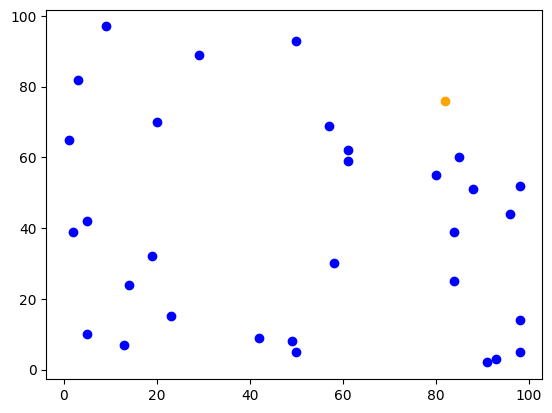

In [3]:
plt.scatter(cvrp_instance.customer_x, cvrp_instance.customer_y, c='blue')
plt.scatter(cvrp_instance.depot_x, cvrp_instance.depot_y, c='orange')
plt.show()

In [4]:
def unify_dist_mtx(depot_coor, client_coor, return_points=False):
	unified_cor = np.append([depot_coor], client_coor, axis=0)
	n_nodes     = unified_cor.shape[0]
	dist_mtx    = np.zeros((n_nodes, n_nodes))

	for i in range(n_nodes):
		for j in range(i, n_nodes):
			dist_mtx[i][j] = dist_mtx[j][i] = np.linalg.norm(
				unified_cor[i] - unified_cor[j]
			)
	if return_points:
		return (dist_mtx, unified_cor)
	return dist_mtx

dist_mtx = unify_dist_mtx(
	(cvrp_instance.depot_x, cvrp_instance.depot_y),
	list(zip(cvrp_instance.customer_x, cvrp_instance.customer_y))
)

print(dist_mtx.shape)

(32, 32)


In [5]:
# Load your CVRP instance
# file_path = "Vrp-Set-A\A\A-n32-k5.vrp"
cvrp_instance = read_cvrp_instance(file_path)
dist_mtx, pts = unify_dist_mtx(
    (cvrp_instance.depot_x, cvrp_instance.depot_y),
    list(zip(cvrp_instance.customer_x, cvrp_instance.customer_y)),
    return_points=True
)

plotter = aco.ACOPlotter(pts)

# Create an AntColonyOptimization instance
aco_solver = aco.NTargetsACO(
    dist_mtx    = dist_mtx,
    demand      = cvrp_instance.customer_demands,
    max_capacity= cvrp_instance.capacity,
    n_paths     = cvrp_instance.num_trucks,
    n_ants      = 50,
    plot_function=plotter.path_plot,
    max_it          = 900,
    evaporation_rate= 0.01,
    overwork_penalty= 180.0,
    dir_balance     = 1.0,
    alpha  = 1.0,
    betha  = 1.1,
    verbose= False
)

# Solve the CVRP using Ant Colony Optimization
best_solution, best_length = aco_solver.solve()

# Display the best solution and its length
print("Best Solution:        ", best_solution)
print("Best Solution Length: ", best_length)
print("Best Solution Fitness:", aco_solver.best_ant_fit)
print("Overwork:             ", (aco_solver.best_ant_fit - best_length)/aco_solver.overwork_pen)
print("Extra cost:           ", aco_solver.path_cost(best_solution))

part COMMENT : (Augerat et al
part  No of trucks: 5
Best Solution:         [ 0 27 24 14  6 29 25  5 20  0 30 26 16  1 12  7 13  0 17 19 31 21 11  4
 18  8  0 10 15 22  9  2  3 23 28  0]
Best Solution Length:  976.2953463508057
Best Solution Fitness: 2776.2953463508056
Overwork:              10.0
Extra cost:            45.0


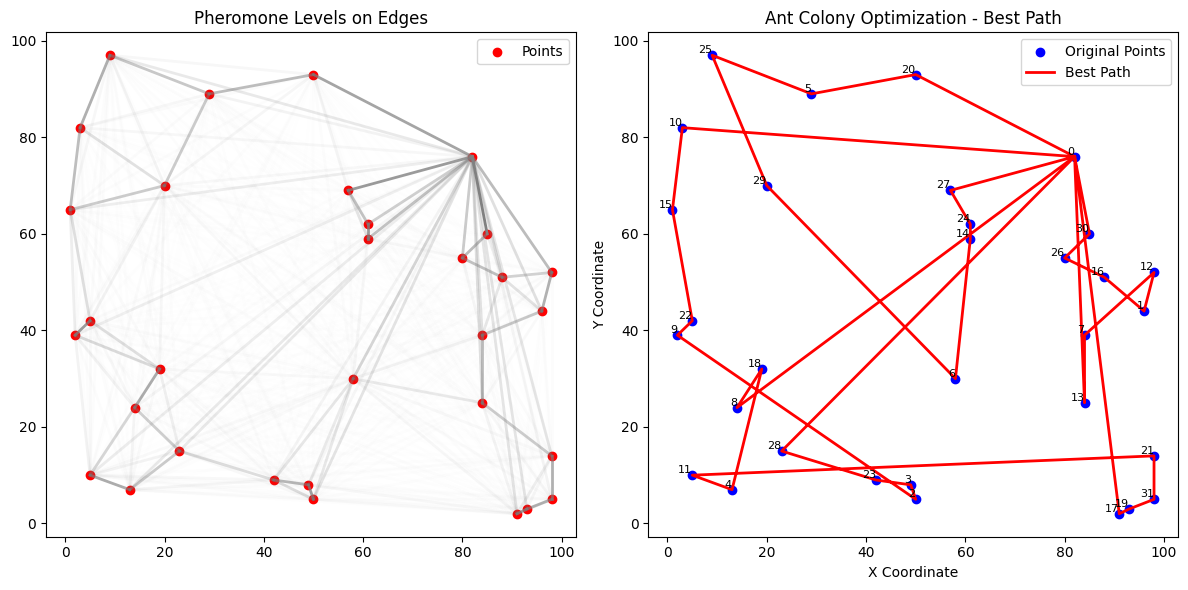

In [6]:
# plotter.draw_path(aco_solver)
plotter.path_plot(aco_solver)
# aco.ACOPlotter.draw_path(pts[:,0], pts[:,1], best_solution)